In [1]:
# Preamble
from astropy.table import Table, column
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### Load the data

In [2]:
gz_data = Table.read('../fits/full_sample_debiased_w_low_z.fits') # galaxies data
samples = Table.read('../fits/SF_fits/samples.fits') # galaxy samples data

In [3]:
sparcfire_g = Table.read('../sparcfire_directories/main/sparcfire_g_matched.fits') # sparcfire data

In [4]:
sparcfire_g_arcs = pd.read_csv('../sparcfire_directories/g/g.galaxy_arcs.csv') # individual arc data

#### Now create our samples, using masks

In [39]:
# Look for spirals (Hart+17 method), which have been successfully reduced in sparcfire
in_spiral = (samples['in_mass_limit']) & (samples['all_spiral'])
in_sparcfire = sparcfire_g['fit_state'] == 'OK'
sparcfire_spirals = np.all([in_spiral,in_sparcfire],axis=0)

# Convert sparcfire chiralitites to binary values (for fast lookup)
id_column = np.array(sparcfire_g['name']).astype(np.int64)
chirality_column = np.array(sparcfire_g['chirality_wtdPangSum'] == 'S-wise').astype(np.int)
chi_array = np.array([id_column,chirality_column]).T

In [40]:
def measure_weighted_average(data,columns):
    p_array = np.array([data[c] for c in columns]).T
    p_array[np.isfinite(p_array) == False] = 0
    p_mean = np.zeros(len(p_array))
    p_sum = np.sum(p_array,axis=1)
    for c in range(len(columns)):
        p_mean += (c+1)*p_array[:,c]
    p_mean = p_mean/p_sum
    p_mean[np.isfinite(p_mean) == False] = 0
    p_absolute = np.argmax(p_array,axis=1) + 1
    return p_mean, p_absolute

m_columns = ['t11_arms_number_a31_1_debiased_rh',
             't11_arms_number_a32_2_debiased_rh',
             't11_arms_number_a33_3_debiased_rh',
             't11_arms_number_a34_4_debiased_rh',
             't11_arms_number_a36_more_than_4_debiased_rh']

w_columns =  ['t10_arms_winding_a28_tight_debiased_rh',
              't10_arms_winding_a29_medium_debiased_rh',
              't10_arms_winding_a30_loose_debiased_rh']

m_wtd_average, m_absolute = measure_weighted_average(gz_data,m_columns)
w_wtd_average, w_absolute = measure_weighted_average(gz_data,w_columns)
gz_statistics = Table(np.array([m_wtd_average,m_absolute,w_wtd_average,w_absolute]).T,
                      names=('m_wtd_avg','m','w_wtd_avg','w'),
                      dtype=(float,int,float,int))

spiral_statistics = gz_statistics[sparcfire_spirals]

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


#### In bins of $m_\mathrm{wtd \, avg}$, at what length should we cut the data?
1. Using a _single_ length cut?
2. Investigate a _variable_ length cut?
3. Compare pitch angles?

#### Considerations:
- log space (ie. effectively 'downweighting' the top end)
- $N$ or $N_\mathrm{wtd \, avg}$

In [59]:
from scipy.stats import spearmanr, pearsonr
from scipy.optimize import curve_fit
from lookup_arcs import ArcLookup, ArcStats # my class for measuring arc statistics
from xy_plots import x_vs_y # my class for binning and plotting
from bin_statistics import assign_bins # my binning class

colors = 'bgyrmk'

In [41]:
# Here, we'll get all of the individual arc data into rows to map onto gz_data

ids = sparcfire_g['dr8objid'][sparcfire_spirals]

arc_table = Table(names=('id','N','P','L','intensity','N_pixels','L_f'),
                  dtype=(int,int,object,object,object,object,object))

for id_ in ids:
    a = ArcLookup(id_)
    chi = a.chirality(chi_array)
    arc_list = a.arc_list(sparcfire_g_arcs,chi)
    arc_table.add_row(arc_list)
    
arc_table_all = Table(np.zeros((len(gz_data),7)),
                      names=('id','N','P','L','intensity','N_pixels','L_f'),
                      dtype=(int,int,object,object,object,object,object))
arc_table_all[sparcfire_spirals] = arc_table

/home/ppxrh/anaconda3/lib/python3.4/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(2269, 20) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:55: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(2269, 40) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(2269, 60) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/nump

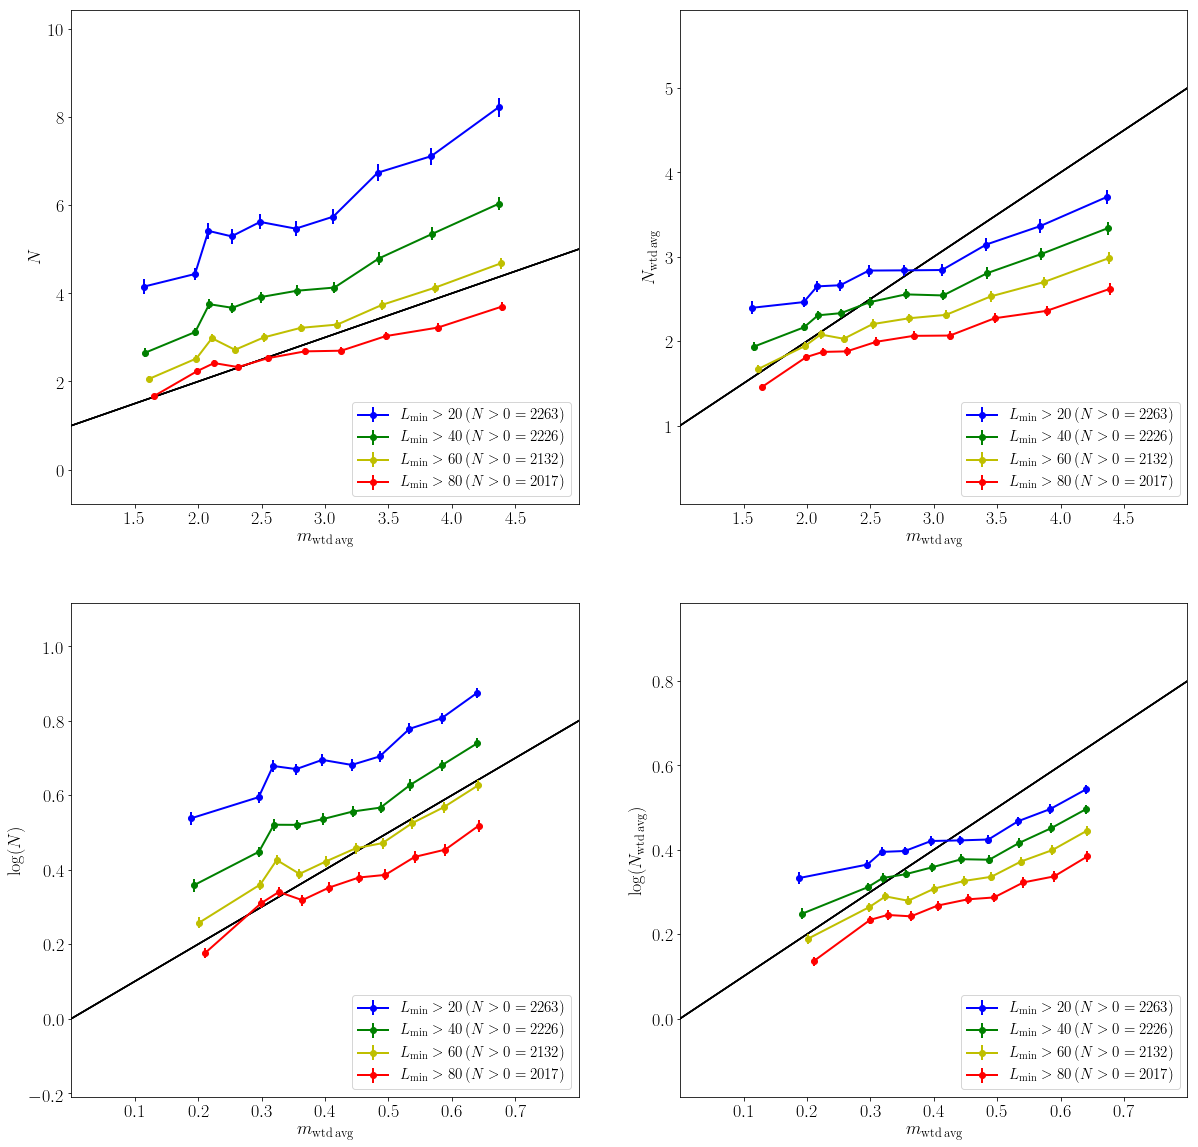

In [58]:
def px_plot(x,y,ax,px,log=True,
            xlabel='$m_\mathrm{wtd_avg}$',ylabel='$N_\mathrm{wtd \, avg}$',
            guideline=False,legend=False,**kwargs):
    if log is True:
        ok = np.all([np.isfinite(x),np.isfinite(y)],axis=0)
    else:
        ok = np.all([x>0,y>0],axis=0)
    xy = x_vs_y(x[ok],y[ok])
    px_string = px if isinstance(px,(int,float)) else '\mathrm{{var}}'
    xy_label = '$L_\mathrm{{min}}>{} \, (N>0={})$'.format(px_string,ok.sum())
    xy.continuous_vs_continuous_binned(ax,bins=10,equal_N=True,
                                       label=xy_label,**kwargs)
    ax.set_xlabel('$m_\mathrm{wtd \, avg}$')
    ax.set_ylabel(ylabel)
    return None

def plot_guidelines(axarr,guideline=True,legend=True):
    for ax in axarr:
        if guideline is True:
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            xymin, xymax = min(xmin,ymin), max(xmax,ymax)
            ax.plot([xymin,xymax],[xymin,xymax],'k-',zorder=-1)
        if legend is True:
            ax.legend(loc='lower right',fontsize=15)
    return None

fig, axarr = plt.subplots(2,2,figsize=(20,20))
axarr = axarr.ravel()

m_wtd_avg = spiral_statistics['m_wtd_avg'] # x-axis data

for p, px_min in enumerate([20,40,60,80]):
    N_wtd_avg = ArcStats(arc_table).N_weighted_average(px_min)
    N_total = ArcStats(arc_table).N_arcs_L(px_min)
    ax = axarr[0]
    px_plot(m_wtd_avg,N_total,ax,px_min,False,
            '$m_\mathrm{wtd \, avg}$','$N$',
            color=colors[p],linewidth=2,capthick=2,marker='o')
    ax.set_xlim(1,5)
    
    ax = axarr[1]
    px_plot(m_wtd_avg,N_wtd_avg,ax,px_min,False,
            '$m_\mathrm{wtd \, avg}$','$N_\mathrm{wtd \, avg}$',
            color=colors[p],linewidth=2,capthick=2,marker='o')
    ax.set_xlim(1,5)
    
    ax = axarr[2]
    px_plot(np.log10(m_wtd_avg),np.log10(N_total),ax,px_min,True,
            '$\log(m_\mathrm{wtd \, avg})$','$\log(N)$',
            color=colors[p],linewidth=2,capthick=2,marker='o')
    ax.set_xlim(0,0.8)
    
    ax = axarr[3]
    px_plot(np.log10(m_wtd_avg),np.log10(N_wtd_avg),ax,px_min,True,
            '$\log(m_\mathrm{wtd \, avg})$','$\log(N_\mathrm{wtd \, avg})$',
            color=colors[p],linewidth=2,capthick=2,marker='o')
    ax.set_xlim(0,0.8)
    
    plot_guidelines(axarr)

#### To at least test whether a fit to the data is reasonable, we will do the most basic possible fit (linear)

---> This shoul _at least_ be able to fit the data slightly better, ie. go the right way

In [61]:
# Now to calculate the 'best' L_min on an arc by arc basis

def find_best_L(x,function,log=False):
    xbins = assign_bins(x,equal_N=True)
    N_bins = np.unique(xbins).size
    x_means = np.empty(N_bins)
    L_bests = np.empty(N_bins)
    L_tests = np.linspace(0,100,21)
    chi_array = np.empty(L_tests.size)
    for b, bin_ in enumerate(np.unique(xbins)):
        in_bin = xbins == bin_
        xbin = x[in_bin]
        x_means[b] = np.mean(xbin)
        for i, L in enumerate(L_tests):
            N_arcs = function(L)
            ok_N = N_arcs > 0
            N_arcs = np.log10(N_arcs) if log is True else N_arcs 
            chi = N_arcs[(in_bin) & (ok_N)] - x[(in_bin) & (ok_N)]
            chi_array[i] = np.absolute(chi.mean())
        best_L = L_tests[np.argmin(chi_array)]
        L_bests[b] = best_L
    return x_means, L_bests


def linear(x,m,c):
    return m*x + c


def scatter(x,y,ax,xlabel='$m_\mathrm{wtd \, avg}$',
            ylabel='$L_\mathrm{min, \, best}$',**kwargs):
    ax.scatter(x,y,**kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return None


def find_and_plot_curve_fit(x,y,ax,function=linear,**kwargs):
    x_min, x_max = ax.get_xlim()
    x_guide = np.linspace(x_min,x_max,1000)
    p, _ = curve_fit(function,x,y)
    ax.plot(x_guide,function(x_guide,*p),**kwargs)
    return p

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


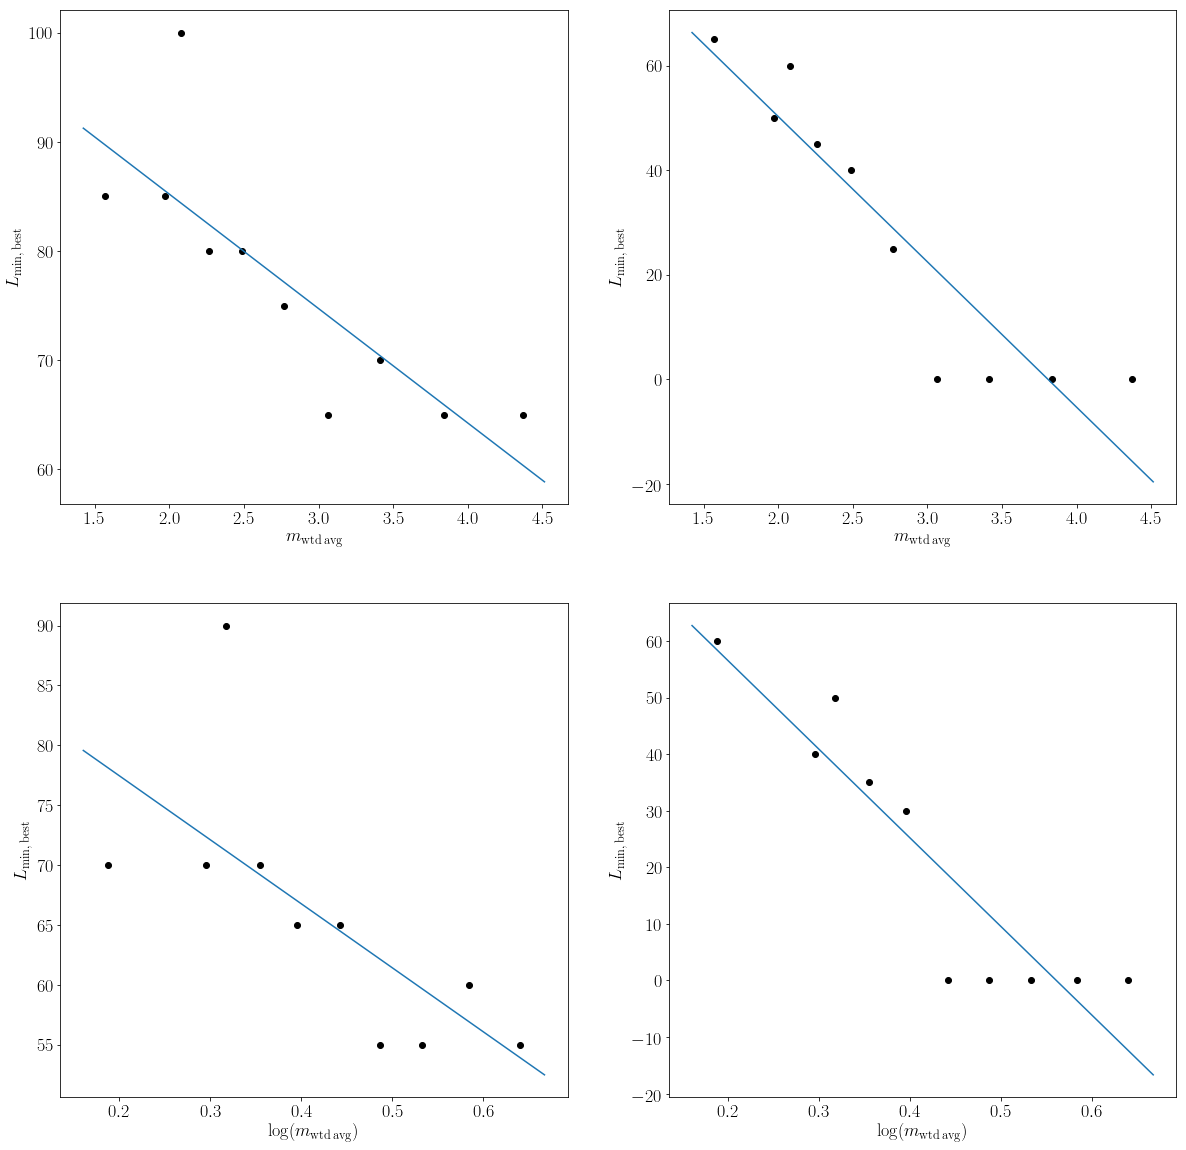

In [98]:
fig, axarr = plt.subplots(2,2,figsize=(20,20))
axarr = axarr.ravel()
#################
x = spiral_statistics['m_wtd_avg']
ax = axarr[0]
x0, L0 = find_best_L(x,ArcStats(arc_table).N_arcs_L,log=False)
_ = scatter(x0,L0,ax,color='k')
p0 = find_and_plot_curve_fit(x0,L0,ax)
#################
ax = axarr[1]
x1, L1 = find_best_L(x,ArcStats(arc_table).N_weighted_average,log=False)
_ = scatter(x1,L1,ax,color='k')
p1 = find_and_plot_curve_fit(x1,L1,ax)
#################
ax = axarr[2]
x2, L2 = find_best_L(np.log10(x),ArcStats(arc_table).N_arcs_L,log=True)
_ = scatter(x2,L2,ax,'$\log(m_\mathrm{wtd \, avg})$',color='k')
p2 = find_and_plot_curve_fit(x2,L2,ax)
#################
ax = axarr[3]
x3, L3 = find_best_L(np.log10(x),ArcStats(arc_table).N_weighted_average,log=True)
_ = scatter(x2,L3,ax,'$\log(m_\mathrm{wtd \, avg})$',color='k')
p3 = find_and_plot_curve_fit(x3,L3,ax)

### Now do the same for a series of fixed cuts
- This is essentially what we plot in the 4 panel plots with 4 colours above, but for a more continuous range.

In [128]:
# Here, we are simply going over a range of possible L cuts (20-100) and find the best agreement in each case

def measure_chi(x,y,logged=False,log=False):
    if (logged is False) and (log is True):
        x, y = np.log10(x), np.log10(y)    
    elif (logged is True) and (log is False):
        x, y = 10**(x), 10**(y)
    ok = ((np.all([np.isfinite(x),np.isfinite(y)],axis=0) if log is True 
          else np.all([x>0,y>0],axis=0)))
    
    absolute_chi = np.absolute(x[ok]-y[ok])
    chi_mean = np.mean(absolute_chi)
    return chi_mean

def find_best_px(x,function,pxs=np.linspace(20,100,81),log=False,
                 return_values=False):
    chi_array = np.empty(pxs.size)
    for p, px in enumerate(pxs):
        y = function(px)
        chi = measure_chi(x,y,log=log)
        chi_array[p] = chi
    best_index = chi_array.argmin()
    best_px = pxs[best_index]
    if return_values is True:
        return pxs, chi_array
    else:
        return best_px

px_absolute0 = find_best_px(m_wtd_avg,ArcStats(arc_table).N_arcs_L)
px_absolute1 = find_best_px(m_wtd_avg,ArcStats(arc_table).N_weighted_average)
px_absolute2 = find_best_px(m_wtd_avg,ArcStats(arc_table).N_arcs_L,log=True)
px_absolute3 = find_best_px(m_wtd_avg,ArcStats(arc_table).N_weighted_average,log=True)

N_total00 = ArcStats(arc_table).N_arcs_L(px_absolute0)
N_wtd_avg10 = ArcStats(arc_table).N_weighted_average(px_absolute1)
N_total20 = ArcStats(arc_table).N_arcs_L(px_absolute2)
N_wtd_avg30 = ArcStats(arc_table).N_weighted_average(px_absolute3)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


In [129]:
for px in [px_absolute0,px_absolute1,px_absolute2,px_absolute3]:
    print(px)

83.0
41.0
76.0
29.0


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


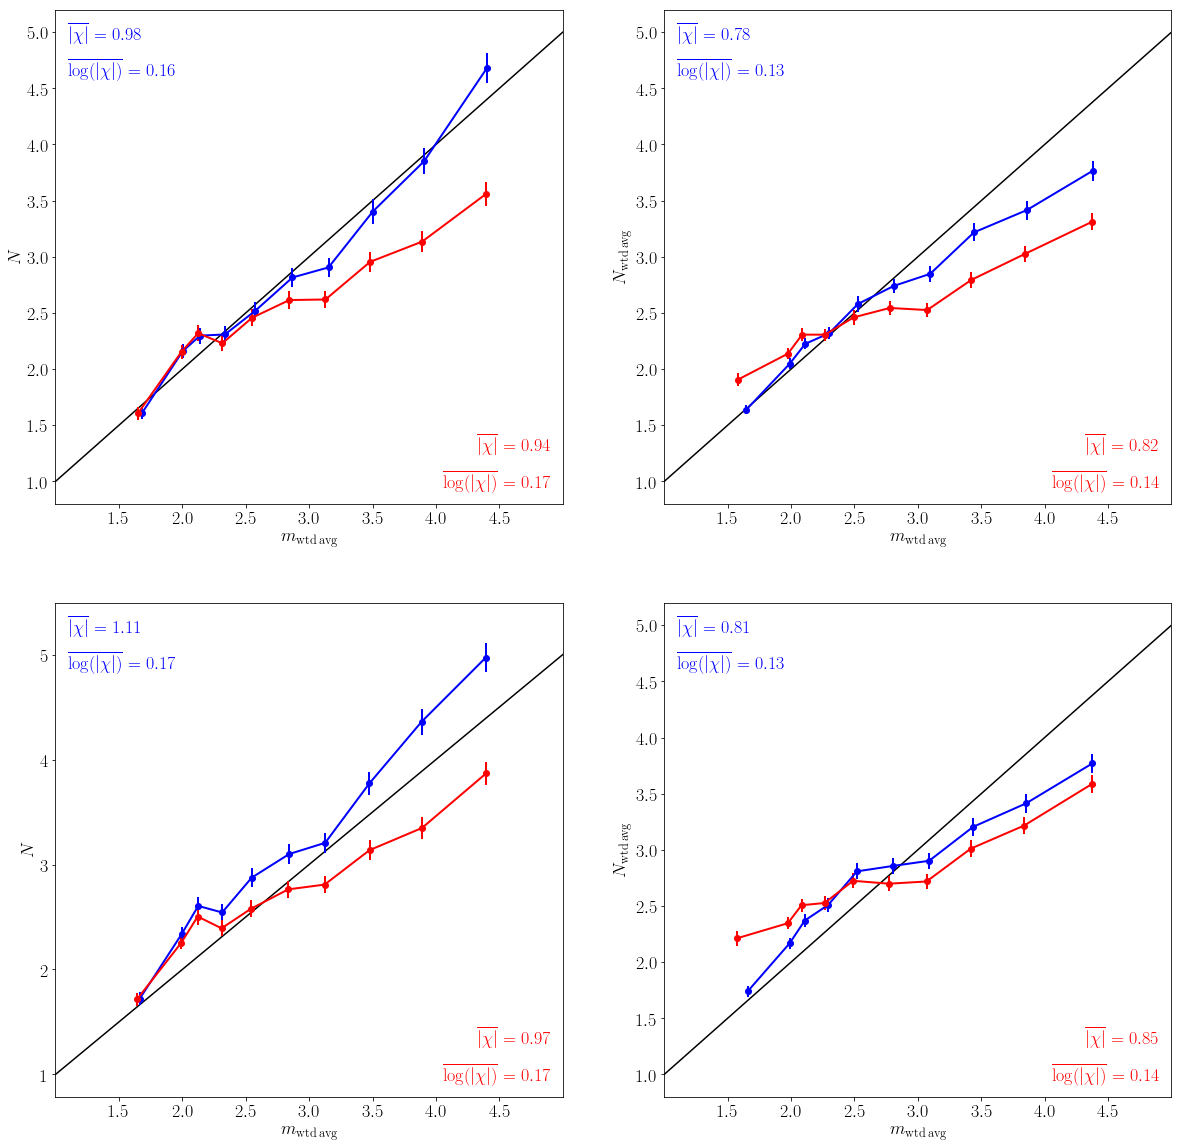

In [130]:


fig, axarr = plt.subplots(2,2,figsize=(20,20))
axarr = axarr.ravel()

m_wtd_avg = spiral_statistics['m_wtd_avg']

def multiplot_N(ax,x,N00,linear_params,px_absolute=0,log=False,
                N_equation=ArcStats(arc_table).N_arcs_L,
                xlabel='$m_\mathrm{wtd \, avg}$',ylabel='$N_\mathrm{wtd \, avg}$'):
    if log is False:
        px_min = linear(x,*linear_params)
    else:
        px_min = linear(np.log10(x),*linear_params)
    N0 = N_equation(px_min)
    px_plot(x,N0,ax,px_min,False,
            '$m_\mathrm{wtd \, avg}$','$N$',
            color='b',linewidth=2,capthick=2,marker='o')
    px_plot(x,N00,ax,px_absolute,False,
            '$m_\mathrm{wtd \, avg}$','$N$',
            color='r',linewidth=2,capthick=2,marker='o')
    ax.set_xlim(1,5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ############### chi labels ###########
    chi0 = measure_chi(x,N0,log=False)
    logchi0 = measure_chi(x,N0,log=True)
    chi00 = measure_chi(x,N00,log=False)
    logchi00 = measure_chi(x,N00,log=True)
    ax.text(0.025,0.975,'$\overline{{|\chi|}}={}$'.format(np.round(chi0,decimals=2)),
            color='b',transform=ax.transAxes,ha='left',va='top')
    ax.text(0.025,0.9,'$\overline{{\log(|\chi|)}}={}$'.format(np.round(logchi0,decimals=2)),
            color='b',transform=ax.transAxes,ha='left',va='top')
    ax.text(0.975,0.1,'$\overline{{|\chi|}}={}$'.format(np.round(chi00,decimals=2)),
            color='r',transform=ax.transAxes,ha='right',va='bottom')
    ax.text(0.975,0.025,'$\overline{{\log(|\chi|)}}={}$'.format(np.round(logchi00,decimals=2)),
            color='r',transform=ax.transAxes,ha='right',va='bottom')

    return ax

ax = axarr[0]
multiplot_N(ax,m_wtd_avg,N_total00,p0,px_absolute=px_absolute0,
          ylabel='$N$')

ax = axarr[1]
multiplot_N(ax,m_wtd_avg,N_wtd_avg10,p1,px_absolute=px_absolute1,
          N_equation=ArcStats(arc_table).N_weighted_average)

ax = axarr[2]
multiplot_N(ax,m_wtd_avg,N_total20,p2,px_absolute=px_absolute2,log=True,
            ylabel='$N$')

ax = axarr[3]
multiplot_N(ax,m_wtd_avg,N_wtd_avg30,p3,px_absolute=px_absolute3,log=True,
          N_equation=ArcStats(arc_table).N_weighted_average)

plot_guidelines(axarr,legend=False)

### Now the final check: does w_wtd_avg correlate with P?

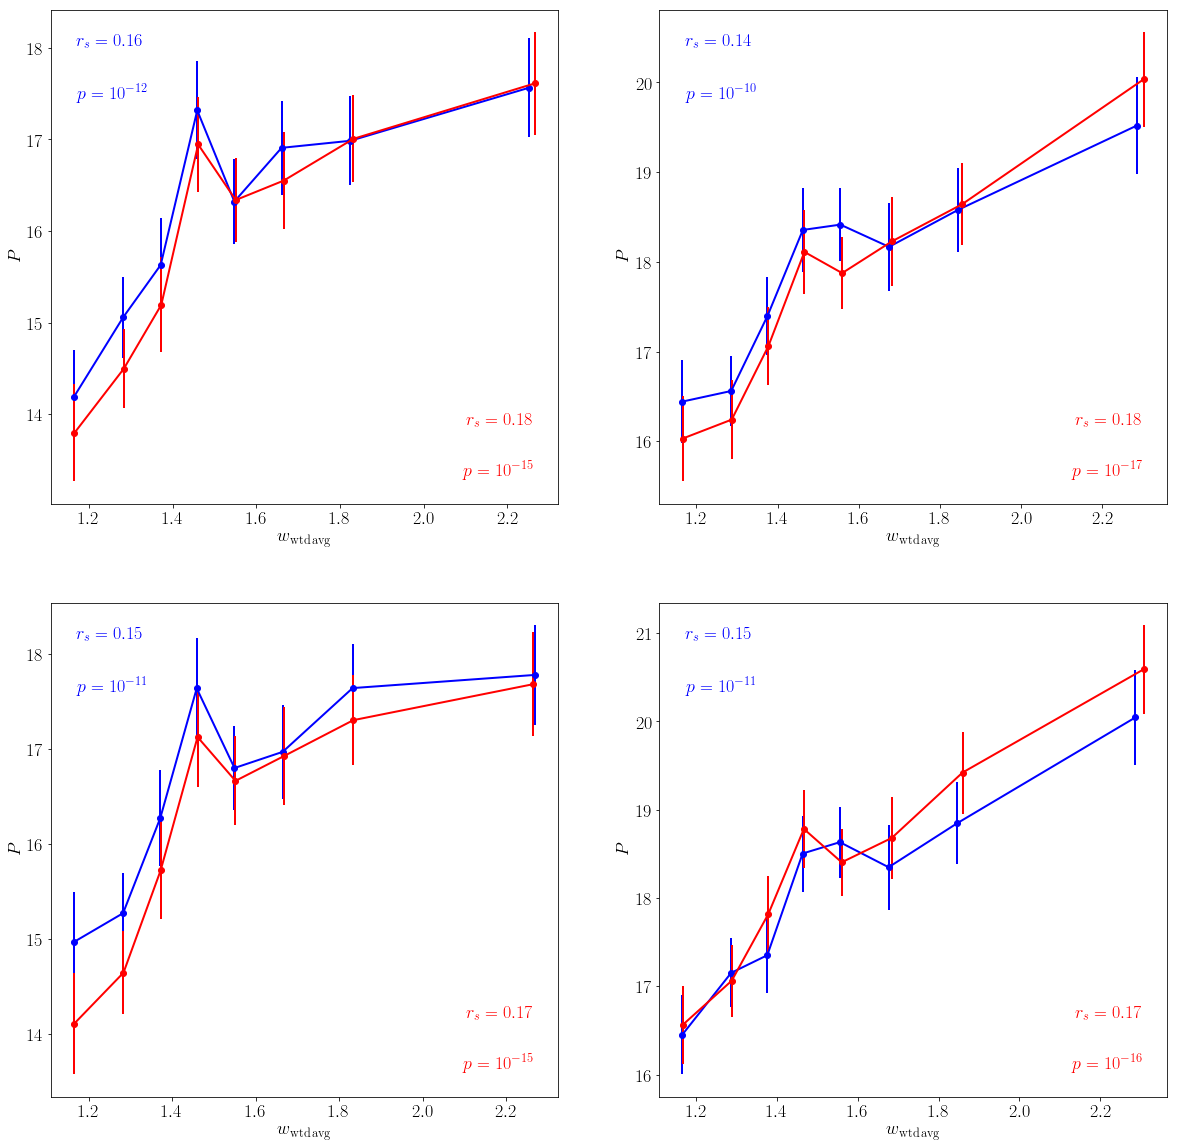

In [136]:
def multiplot_P(ax,x,px_variable,px_absolute,weighted_average=True,
                xlabel='$w_\mathrm{wtd \, avg}$',ylabel='$P$'):
    
    P_variable = ArcStats(arc_table).P_average(px_variable,weighted_average)
    P_absolute = ArcStats(arc_table).P_average(px_absolute,weighted_average)
    ok_P_variable = P_variable > 0
    ok_P_absolute = P_absolute > 0
    xy = x_vs_y(w_wtd_avg[ok_P_variable],P_variable[ok_P_variable])
    xy.continuous_vs_continuous_binned(ax,color='b',marker='o',linewidth=2,capthick=2,
                                       bins=8,equal_N=True)
    xy.show_spearmanr(ax,location='upper left',color='b')
    xy = x_vs_y(w_wtd_avg[ok_P_absolute],P_absolute[ok_P_absolute])
    xy.continuous_vs_continuous_binned(ax,color='r',marker='o',linewidth=2,capthick=2,
                                       bins=8,equal_N=True)
    xy.show_spearmanr(ax,location='lower right',color='r')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

fig, axarr = plt.subplots(2,2,figsize=(20,20))
axarr = axarr.ravel()
    
w_wtd_avg = spiral_statistics['w_wtd_avg']

ax = axarr[0]
multiplot_P(ax,w_wtd_avg,px_min0,px_absolute0)

ax = axarr[1]
multiplot_P(ax,w_wtd_avg,px_min1,px_absolute1)

ax = axarr[2]
multiplot_P(ax,w_wtd_avg,px_min2,px_absolute2)

ax = axarr[3]
multiplot_P(ax,w_wtd_avg,px_min3,px_absolute3)

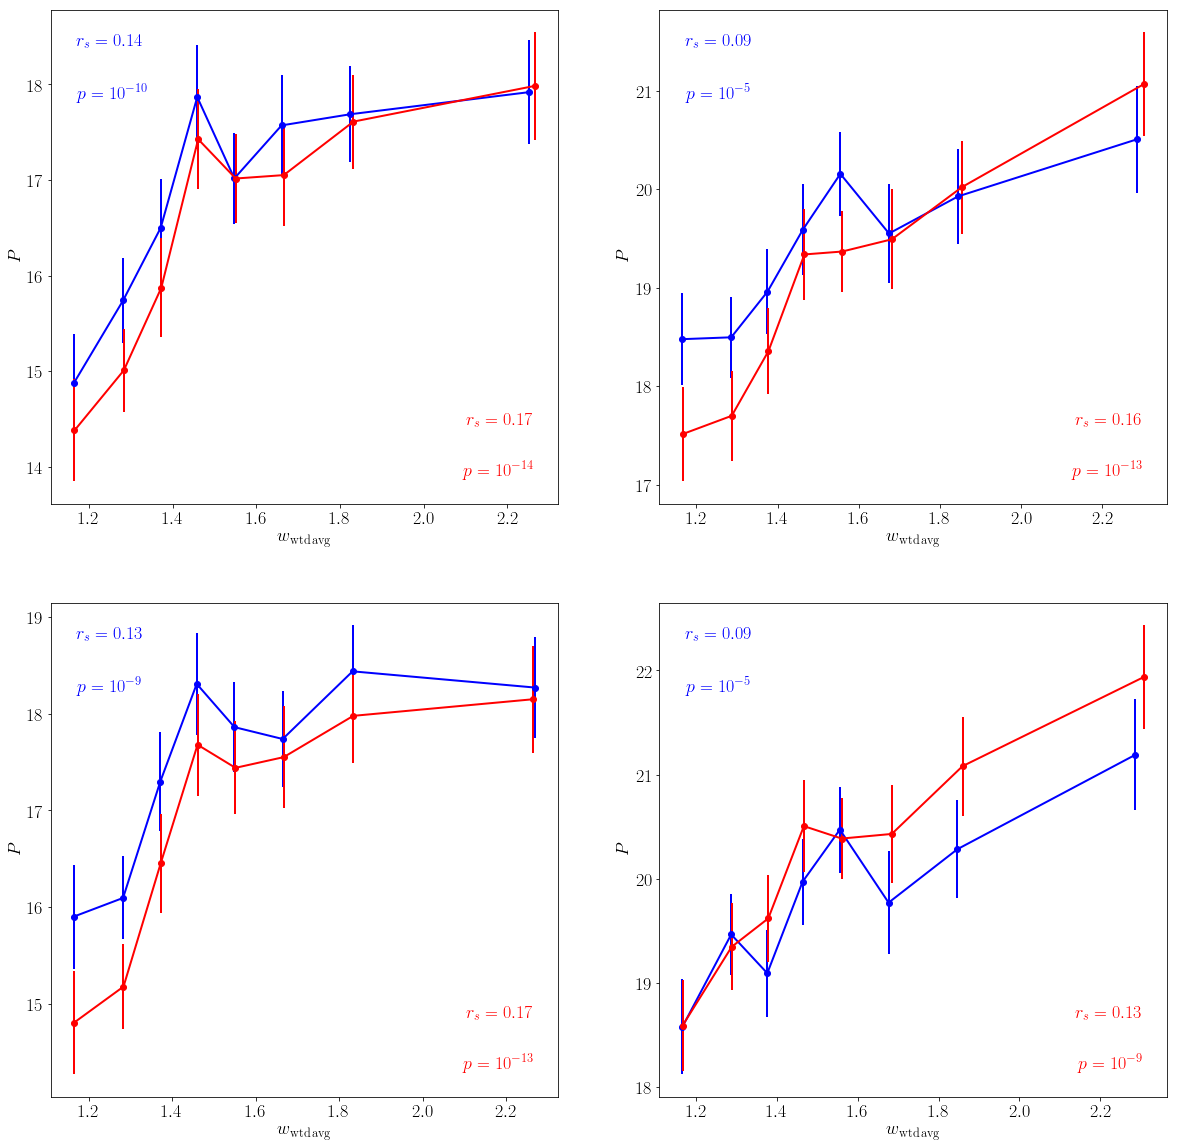

In [137]:
fig, axarr = plt.subplots(2,2,figsize=(20,20))
axarr = axarr.ravel()
    
w_wtd_avg = spiral_statistics['w_wtd_avg']

ax = axarr[0]
multiplot_P(ax,w_wtd_avg,px_min0,px_absolute0,
            weighted_average=False)

ax = axarr[1]
multiplot_P(ax,w_wtd_avg,px_min1,px_absolute1,
            weighted_average=False)

ax = axarr[2]
multiplot_P(ax,w_wtd_avg,px_min2,px_absolute2,
            weighted_average=False)

ax = axarr[3]
multiplot_P(ax,w_wtd_avg,px_min3,px_absolute3,
            weighted_average=False)